# Advanced Annotation Vectors

This tutorial is the second part of a two-part series of tutorials and it summarizes the findings of the [Matrix Profile V](https://www.cs.ucr.edu/~eamonn/guided-motif-KDD17-new-format-10-pages-v005.pdf) paper and replicates the presented case studies.

In the [Basics of Annotation Vectors](https://stumpy.readthedocs.io/en/latest/Tutorial_Advanced_Annotation_Vectors), we were introduced to the concept of **Guided Motif Search** and **Annotation Vectors,** and how we can use annotation vectors to solve **Actionability Bias.** In this tutorial, we will explore the use of annotation vectors in tackling **Stop-Word Motif Bias** and **Simplicity Bias.**

## Quick Recap

### What is Guided Motif Search?

Guided motif search is the process of suppressing certain portions of a time series from a motif search, either through complete exclusion, or through the penalization of z-normalized Euclidean distance near regions that are undesirable. The process typically involves the generation of an annotation vector.

## What are Annotation Vectors?

An annotation vector contains real-valued numbers between 0 and 1 and can be used to distinguish between the important/unimportant subsequences within your time series (with 0 indicating undesirable and 1 indicating desirable). Annotation vectors for a time series can be combined with the matrix profile to formulate the **Corrected Matrix Profile** which we can use to identify our desirable motifs. The corrected matrix profile can be acquired using the following formula:

$$
\begin{align*}
CMP[i] &= MP[i] + (1 - AV[i]) \times max(MP)
\end{align*}
$$

$CMP$ is the corrected matrix profile, $MP$ is the original matrix profile, $AV$ is the annotation vector and $max(MP)$ is the maximum value of the original matrix profile. We can test the performance of this formula by computing and visualizing the corrected matrix profile.

## Getting Started

Let’s import the packages that we’ll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from stumpy import stump
from stumpy import mass

plt.style.use('stumpy.mplstyle')

## Stop-Word Motif Bias

As mentioned in the first tutorial, when analyzing the Amazon customer reviews dataset, we would probably want to remove all stop-words before our analysis. We would often like to do something similar in time series motif search. In many time series datasets, there may be visible "stop-word" subsequences, that are expected but contribute to nothing insightful. For the Amazon customer reviews dataset, words like "Amazon", "order", "shipping", "the", "and" would be such examples.

Consider the [ECG data snippet](https://drive.google.com/file/d/0B1ZwONZKxJgTTVJON3Q0aXpZSGc/view?usp=sharing&resourcekey=0-q5yEeGF3D5O7F6Ap8MfqqQ) from the [LTAF-71 dataset](https://physionet.org/content/ltafdb/1.0.0/). **ECG**, or **Electrocardiography** is the measurement of electrical activity of the heart. We start by downloading and visualizing the time series data.

In [2]:
# TO-DO: Replace this with pd.read_csv() once dataset is uploaded to Zenodo
!pip3 install gdown
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTTVJON3Q0aXpZSGc

You are using pip version 18.1, however version 21.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTTVJON3Q0aXpZSGc
To: C:\Users\zzaman\Documents\personal\STUMPY\repos\stumpy\docs\ECG_LTAF_71_subLen_150.mat

  0%|          | 0.00/3.65k [00:00<?, ?B/s]
100%|##########| 3.65k/3.65k [00:00<00:00, 28.9kB/s]
100%|##########| 3.65k/3.65k [00:00<00:00, 28.9kB/s]


In [3]:
dataset = loadmat('ECG_LTAF_71_subLen_150.mat')
ECG_data = dataset['data'][0]

df = {
    'ECG Data': ECG_data,
}

df = pd.DataFrame(df)
df.head()

,ECG Data
0,79
1,84
2,81
3,83
4,81


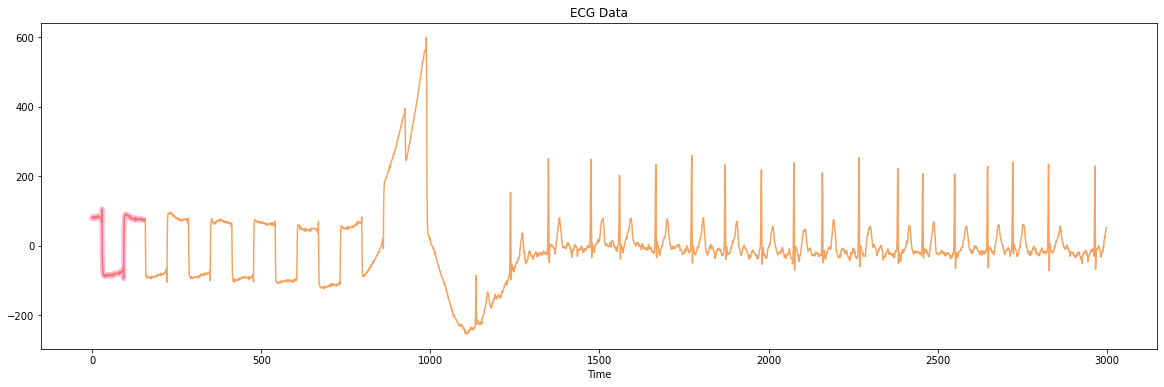

In [4]:
ECG_data = ECG_data.astype(np.float64)
m = 150
stopword = ECG_data[:m]

plt.plot(ECG_data, color='sandybrown', label='ECG Data')
plt.plot(np.array(range(0, m)), stopword, color='deeppink', alpha=0.3, linewidth=5)
plt.xlabel('Time')
plt.title('ECG Data')

plt.show()

The first parts of the time series include several nearly identical square wave signals. These are calibration signals that are sent by the ECG apparatus to indicate that it is switched on. These square waves are not coming from the test subject's heart activity, and, needless to say, these are our "stop-words".

We can compute the matrix profile and locate the nearest neighbors.

In [5]:
def get_motif_data(data, matrix_profile, m):
    motif_index = np.argmin(matrix_profile[:, 0])
    motif_x = np.arange(motif_index, motif_index + m)
    motif_y = data[motif_index:motif_index + m]
    motif = (motif_index, motif_x, motif_y)

    neighbor_index = matrix_profile[motif_index, 1]
    neighbor_x = np.arange(neighbor_index, neighbor_index + m)
    neighbor_y = data[neighbor_index:neighbor_index + m]
    neighbor = (neighbor_index, neighbor_x, neighbor_y)
    
    return motif, neighbor

In [6]:
matrix_profile = stump(ECG_data, m)
motif1, motif2 = get_motif_data(ECG_data, matrix_profile, m)

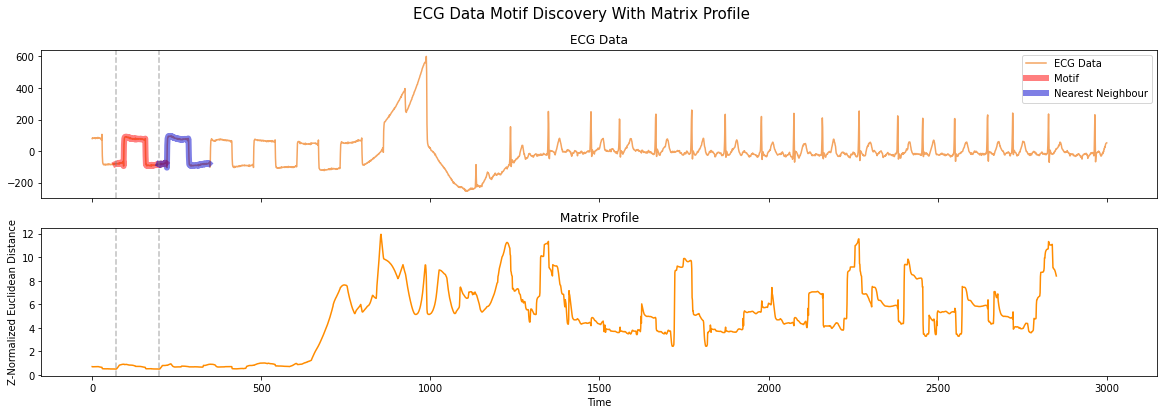

In [7]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('ECG Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(ECG_data, color='sandybrown', label='ECG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('ECG Data')

axis[1].plot(matrix_profile[:, 0], color='darkorange', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

As expected, the motif search only returned subsequences in the calibration region. How do we prevent this? Our objective is to remove anything that looks like the square-wave calibration signal. In order to do that, we must identify something that "looks" like that square wave.

To solve this issue, we compute the distance profile of the time series with a smaller square-wave subsequence. We can accomplish this using the `mass` function from STUMPY.

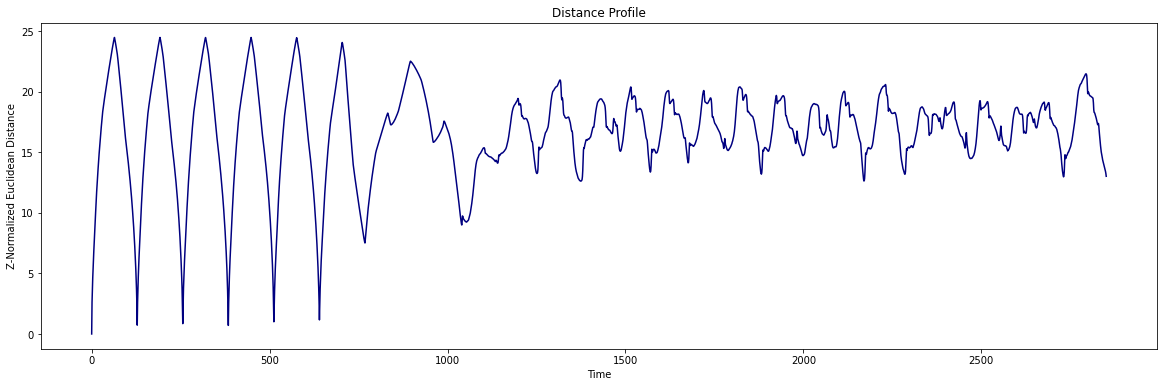

In [8]:
distance_profile = mass(stopword, ECG_data)

plt.plot(distance_profile, color='navy', label='Distance Profile')
plt.xlabel('Time')
plt.ylabel('Z-Normalized Euclidean Distance')
plt.title('Distance Profile')

plt.show()

The distance profile contains bottom peaks near the square-wave calibration signals. This gives us a way to identify the square-wave signals. We can set a threshold in z-normalized Euclidean distance, below which will be regarded as a calibration signal. Then, for any calibration signal, we can set a certain area "near" that signal to be 0 in the annotation vector. Our definition of "near" will be 3m before and after the square-wave signal, where m is the window size, but this definition may vary depending on the dataset and its context.

In [9]:
threshold = 5
annotation_vector = np.ones(len(ECG_data) - m + 1)

for i in range(len(ECG_data) - m + 1):
    if annotation_vector[i] == 0:
        continue
        
    if distance_profile[i] < threshold:
        exclusion_zone_lower_limit = max(0, i - (3 * m))
        exclusion_zone_upper_limit = min(len(ECG_data) - m + 1, i + (3 * m))
        annotation_vector[exclusion_zone_lower_limit:exclusion_zone_upper_limit] = 0

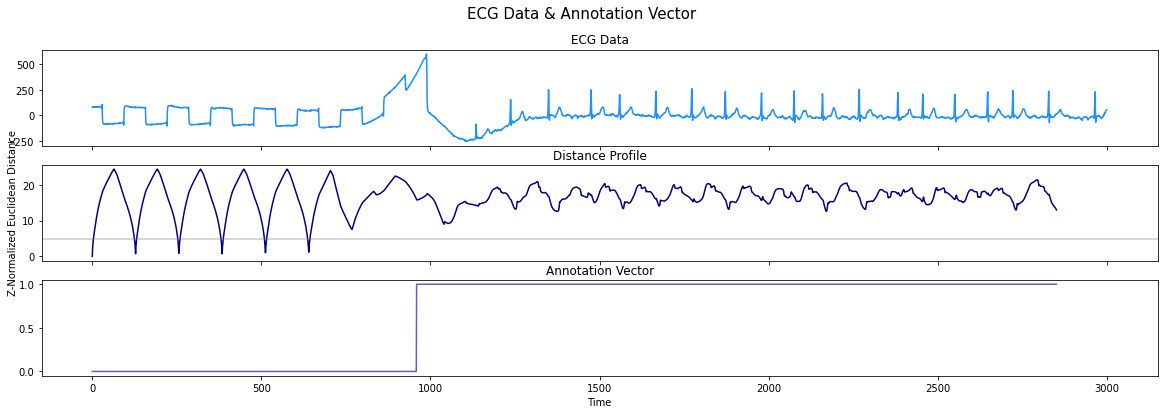

In [10]:
fig, axis = plt.subplots(3, sharex=True)
plt.suptitle('ECG Data & Annotation Vector', fontsize='15')

axis[0].plot(ECG_data, color='dodgerblue', label='ECG Data')
axis[0].set_title('ECG Data')

axis[1].plot(distance_profile, color='navy', label='Distance Profile')
axis[1].axhline(y=threshold, color='slategrey', alpha=0.3, linewidth=2)
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Distance Profile')

axis[2].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[2].set_xlabel('Time')
axis[2].set_title('Annotation Vector')

plt.show()

As we can see, we have produced an annotation vector that is 0 around the calibration region and 1 otherwise. We use to compute the corrected matrix profile.

In [11]:
def get_corrected_matrix_profile(matrix_profile, annotation_vector):
    corrected_matrix_profile = matrix_profile[:, 0] + ((1 - annotation_vector) * np.amax(matrix_profile[:, 0]))
    corrected_matrix_profile = np.column_stack((corrected_matrix_profile, matrix_profile[:, [1, 2, 3]]))
    
    return corrected_matrix_profile

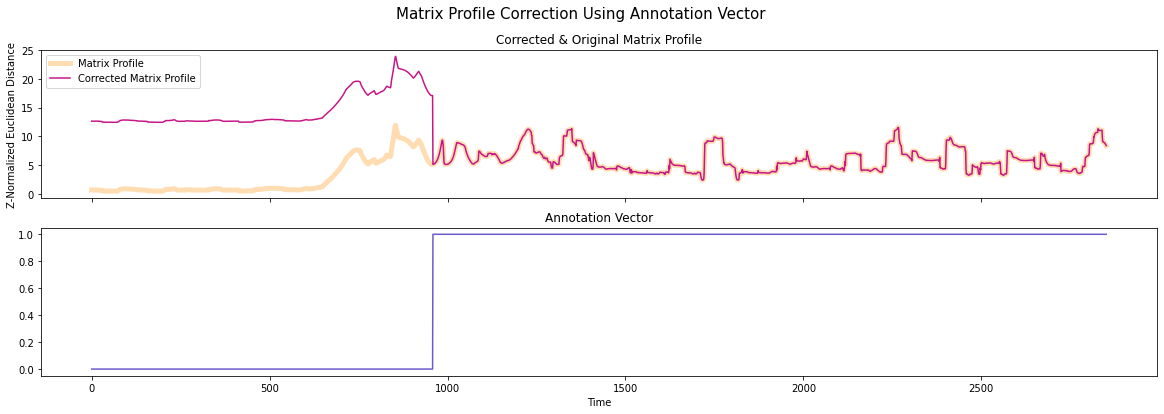

In [12]:
corrected_matrix_profile = get_corrected_matrix_profile(matrix_profile, annotation_vector)
motif1, motif2 = get_motif_data(ECG_data, corrected_matrix_profile, m)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='mediumvioletred', label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

Now we repeat the motif search with the corrected matrix profile.

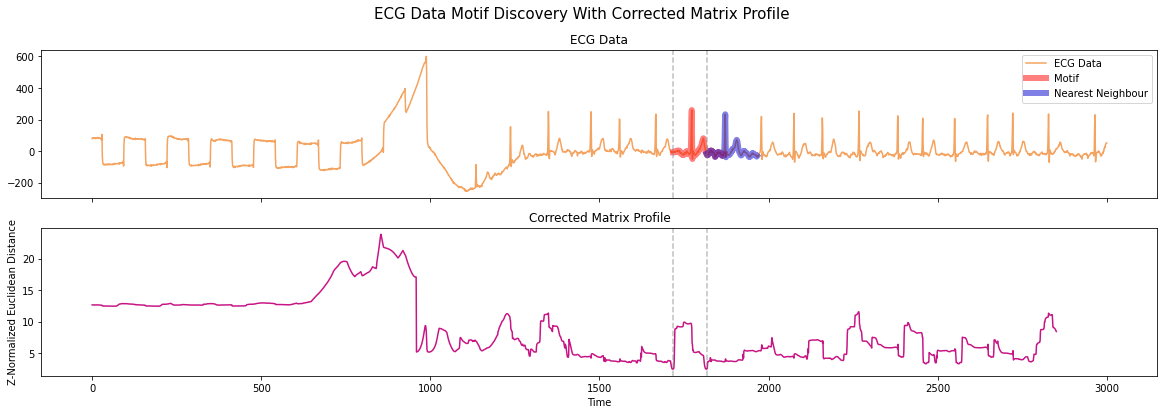

In [13]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('ECG Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(ECG_data, color='sandybrown', label='ECG Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('ECG Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='mediumvioletred', label='Corrected Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

Once again, the motifs have moved away from the undesirable region, onto a more desirable region.

## Simplicity Bias

Simplicity Bias is the tendency of the motif search process to pick out regions where there isn't much activity. Sometimes our time series may include mostly regions of inactivity, with a few chunks of useful data. In such cases, we want to penalize motifs around areas that are "simple".

Consider the [Finger Flexion Dataset](https://drive.google.com/file/d/0B1ZwONZKxJgTZlVYRHRRN2E5aU0/view?usp=sharing&resourcekey=0-uJHqC_VGgfi59qB8zhP7Fw). We start by downloading and visualizing this dataset.

In [14]:
# TO-DO: Replace this with pd.read_csv() once dataset is uploaded to Zenodo
!gdown https://drive.google.com/uc?id=0B1ZwONZKxJgTZlVYRHRRN2E5aU0

Downloading...
From: https://drive.google.com/uc?id=0B1ZwONZKxJgTZlVYRHRRN2E5aU0
To: C:\Users\zzaman\Documents\personal\STUMPY\repos\stumpy\docs\finger_flexion_subLen_3500.mat

  0%|          | 0.00/11.3k [00:00<?, ?B/s]
100%|##########| 11.3k/11.3k [00:00<00:00, 98.3kB/s]
100%|##########| 11.3k/11.3k [00:00<00:00, 97.4kB/s]


In [15]:
dataset = loadmat('finger_flexion_subLen_3500.mat')
finger_flexion_data = dataset['data'][:, 0]

df = {
    'Finger Flexion Data': finger_flexion_data,
}

df = pd.DataFrame(df)
df.head()

,Finger Flexion Data
0,-0.418429
1,-0.410371
2,-0.410371
3,-0.410371
4,-0.410371


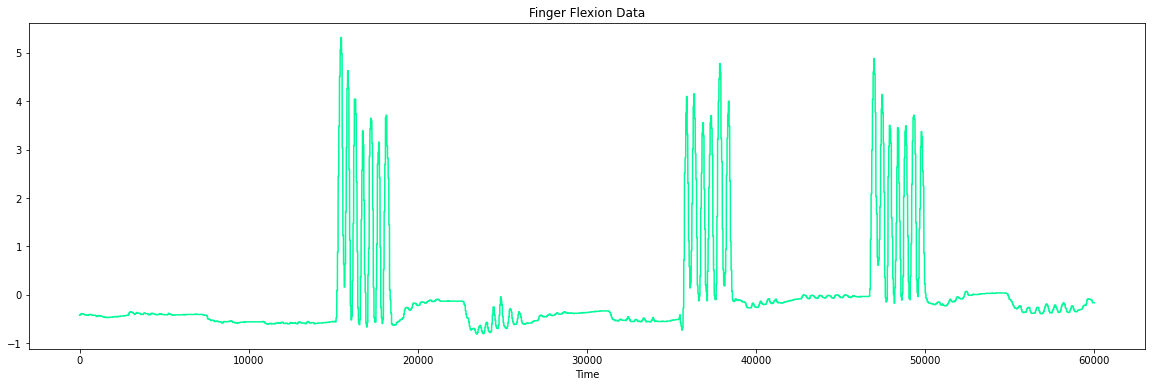

In [16]:
finger_flexion_data = finger_flexion_data.astype(np.float64)

plt.plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
plt.xlabel('Time')
plt.title('Finger Flexion Data')

plt.show()

As we can see, this majority of this time series is not very active, with a few regions of spikes. It's almost completely obvious that a motif search will result in the "simple" areas. We can confirm that by computing the matrix profile and locating the motifs.

In [17]:
m = 3500
matrix_profile = stump(finger_flexion_data, m)
motif1, motif2 = get_motif_data(finger_flexion_data, matrix_profile, m)

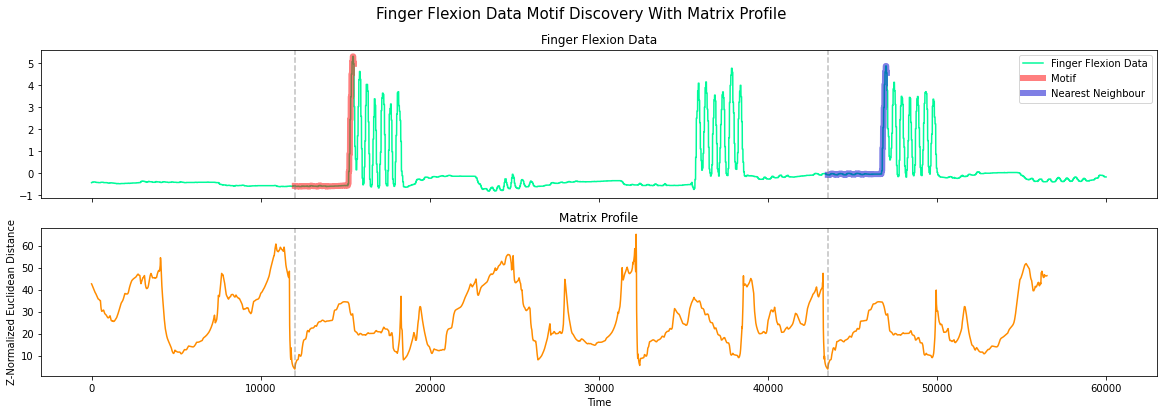

In [18]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Finger Flexion Data Motif Discovery With Matrix Profile', fontsize='15')

axis[0].plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('Finger Flexion Data')

axis[1].plot(matrix_profile[:, 0], color='darkorange', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Matrix Profile')

plt.show()

As we expected, most of the nearest neighbor subsequences consist of a flat, simple region. In order to favor regions of more activity, we must penalize regions that are "simple" and reward regions that are "complex". In order to do that, we need to define "complexity".

There are many ways to define a complex time series subsequence. For the purposes of this tutorial, we can use the complexity estimate formula specified in [A Complexity-Invariant Distance Measure for Time Series](https://link.springer.com/article/10.1007/s10618-013-0312-3) paper:

$$
\begin{align*}
CE(Q) &= \sqrt{\sum\limits^{n - 1}_{i = 1}(q_i - q_{i + 1})^2}
\end{align*}
$$

We can use this definition of a complexity vector to construct an annotation vector that will reward motifs in complex regions.

In [19]:
complexity_vector = np.zeros(len(finger_flexion_data) - m + 1)

for i in range(len(finger_flexion_data) - m + 1):
    CE = np.diff(finger_flexion_data[i:i + m])
    CE = np.power(CE, 2)
    CE = np.sum(CE)
    CE = np.sqrt(CE)
    complexity_vector[i] = CE

annotation_vector = complexity_vector
annotation_vector = annotation_vector - np.amin(annotation_vector)
annotation_vector = annotation_vector / np.amax(annotation_vector)

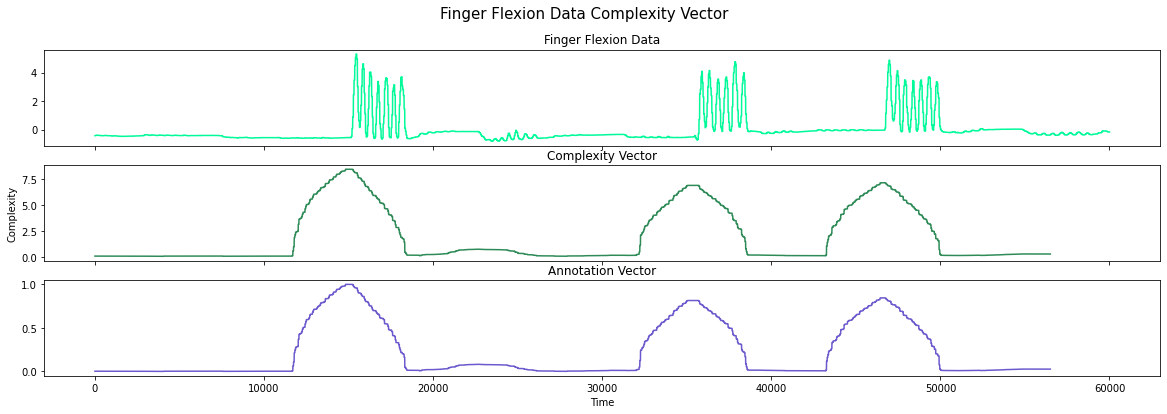

In [20]:
fig, axis = plt.subplots(3, sharex=True)
plt.suptitle('Finger Flexion Data Complexity Vector', fontsize='15')

axis[0].plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
axis[0].set_title('Finger Flexion Data')

axis[1].plot(complexity_vector, color='seagreen', label='Matrix Profile')
axis[1].set_ylabel('Complexity')
axis[1].set_title('Complexity Vector')

axis[2].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[2].set_xlabel('Time')
axis[2].set_title('Annotation Vector')

plt.show()

As we can see, the generated annotation vector is higher around regions that are complex, and lower around regions that are simple. We use this to obtain the corrected matrix profile.

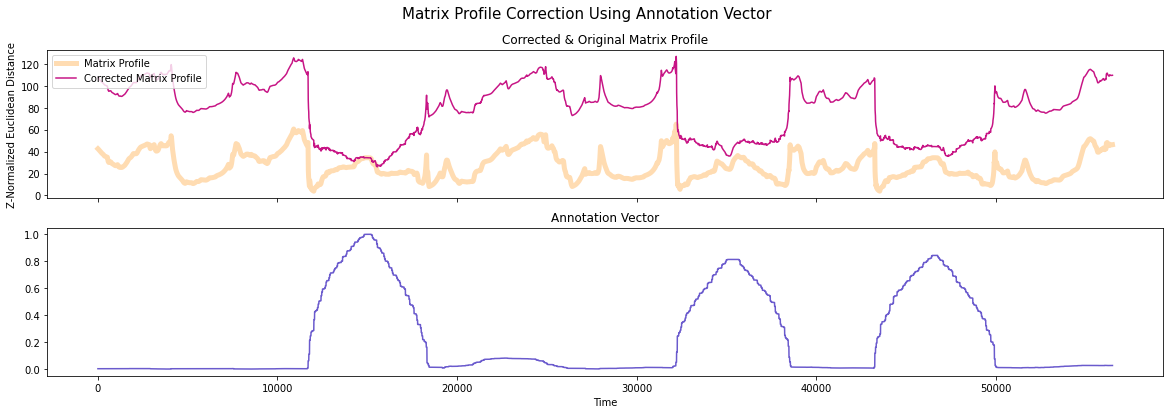

In [21]:
corrected_matrix_profile = get_corrected_matrix_profile(matrix_profile, annotation_vector)
motif1, motif2 = get_motif_data(finger_flexion_data, corrected_matrix_profile, m)

fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Matrix Profile Correction Using Annotation Vector', fontsize='15')

axis[0].plot(matrix_profile[:, 0], color='darkorange', linewidth=5, alpha=0.3, label='Matrix Profile')
axis[0].plot(corrected_matrix_profile[:, 0], color='mediumvioletred', label='Corrected Matrix Profile')
axis[0].set_ylabel('Z-Normalized Euclidean Distance')
axis[0].set_title('Corrected & Original Matrix Profile')
axis[0].legend(loc ='upper left')

axis[1].plot(annotation_vector, color='slateblue', label='Annotation Vector')
axis[1].set_xlabel('Time')
axis[1].set_title('Annotation Vector')

plt.show()

This provides us with a corrected matrix profile that penalizes simplicity. We use this to search for motifs.

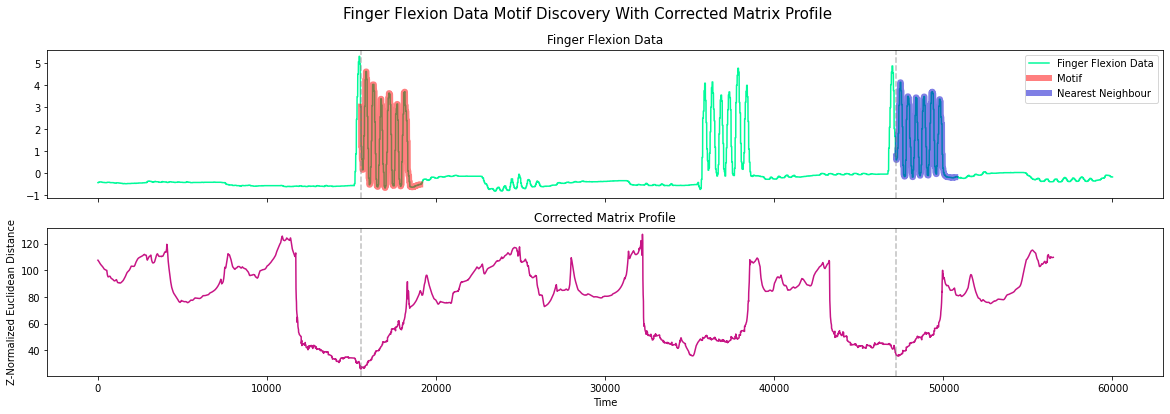

In [22]:
fig, axis = plt.subplots(2, sharex=True)
plt.suptitle('Finger Flexion Data Motif Discovery With Corrected Matrix Profile', fontsize='15')

axis[0].plot(finger_flexion_data, color='mediumspringgreen', label='Finger Flexion Data')
axis[0].plot(motif1[1], motif1[2], color='red', linewidth=6, alpha=0.5, label='Motif')
axis[0].plot(motif2[1], motif2[2], color='mediumblue', linewidth=6, alpha=0.5, label='Nearest Neighbour')
axis[0].legend()
axis[0].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[0].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[0].set_title('Finger Flexion Data')

axis[1].plot(corrected_matrix_profile[:, 0], color='mediumvioletred', label='Matrix Profile')
axis[1].axvline(x=motif1[0], color='grey', alpha=0.5, linestyle='--')
axis[1].axvline(x=motif2[0], color='grey', alpha=0.5, linestyle='--')
axis[1].set_xlabel('Time')
axis[1].set_ylabel('Z-Normalized Euclidean Distance')
axis[1].set_title('Corrected Matrix Profile')

plt.show()

The nearest neighbor subsequences are now near regions of more activity.

## Summary

And that's it! You've now learnt the advanced usages of guided motif search and annotation vectors, and the use of annotation vectors in solving complex cases of time series motif search biases.

## Resources

[Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf)

[STUMPY Basics](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html)

[Matrix Profile V](https://www.cs.ucr.edu/~eamonn/guided-motif-KDD17-new-format-10-pages-v005.pdf)

[Advanced Annotation Vectors](https://stumpy.readthedocs.io/en/latest/Tutorial_Advanced_Annotation_Vectors.html)

[A Complexity-Invariant Distance Measure for Time Series](https://link.springer.com/article/10.1007/s10618-013-0312-3)